# Variational Auto Encoders for Cardiac Shape Modeling

**Supervisor:** Loïc Le Folgoc

**Group:**
* Alice Valença De Lorenci
* Artur Dandolini Pescador
* Giulia Mannaioli
* Lais Isabelle Alves dos Santos

## Objectives

The goal of this project is to implement a convolutional Variational Autoencoder (VAE) in order to build a mapping between a latent space of cardiac shape and 2D segmentation masks of the left ventricle, right ventricle and myocardium. More precisely, the input of the VAE are 4-channel 2D images, each image is the segmentation mask of one cardiac MRI slice and the channels correspond to the segmentation masks of the background, left ventricle, right ventricle and myocardium. The results will be evaluated in terms of the quality of the reconstruction of the segmentation masks.

The main articles consulted during the elaboration of the project were:
1. Biffi, C., et al. (2018) Learning interpretable anatomical features through deep generative models: Application to cardiac remodeling. *International conference on medical image computing and computer-assisted intervention*, 464-471.
2. Painchaud, N., et al. (2020) Cardiac Segmentation with Strong Anatomical Guarantees. *IEEE Transactions on Medical Imaging* 39(11), 3703-3713.

The first article was the main source of inspiration for the project while the architecture chosen for the VAE was based on the one presented in the second article.

This report is organized into the following sections:
- *Dataset*: Description of the dataset and the pre-processing steps.
- *VAE*: Implementation and description of the Variational Autoencoder.
- *Results*: Analysis of the quality of the reconstruction obtained with the VAE.

Furthermore, the following files accompany the project:
- *preprocessing.py*: Implementation of the methods needed to load and pre-process the dataset.
- *model.py*: Class implementing the VAE architecture.
- *model_evaluation.py*: Implementation of the methods used to evaluate the VAE.

## Dataset

The dataset used for this project is that of the [ACDC challenge](https://www.creatis.insa-lyon.fr/Challenge/acdc/databases.html). It consists in a training-validation set of 100 subjects and a test set of 50 subjects. For both cardiac MRI images and the corresponding segmentation maps are provided for end systole (ES) and end diastole (ED). The segmentation map includes the following structures (with respective labels):

0. Background
1. Right ventricle cavity (RV)
2. Myocardium (MY)
3. Left ventricle cavity (LV)

We chose to work only with end diastole (ED) images.

In the cells bellow we define the path to the folder containing the dataset and identify the path to the images contained in the folder.

In [1]:
# detect if it is running on colab
if 'google.colab' in str(get_ipython()):
  colab = True
else:
  colab = False

if colab:
  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)

  import sys
  #path = '/content/drive/MyDrive/Variational-Auto-Encoders-for-cardiac-shape-modeling/' # define path to project folder
  path = '/content/drive/MyDrive/Télécom/2A/IMA/IMA206/project/Variational-Auto-Encoders-for-cardiac-shape-modeling/'
  sys.path.insert(0,path)

  try:
    import torchio
  except:
    import locale
    locale.getpreferredencoding = lambda: "UTF-8"
    !pip install torchio
else:
  path = ''

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.9/172.9 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.5/237.5 kB 32.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 3.7 MB/s eta 0:00:00
  Attempting uninstall: rich
    Found existing installation: rich 13.3.4
    Uninstalling rich-13.3.4:
      Successfully uninstalled rich-13.3.4


In [2]:
# necessary libraries
import os
import nibabel as nib
import numpy as np
import preprocessing as pre

from IPython.display import Image

In [3]:
# Path to folder containing the dataset
if os.path.exists(path+'../ACDC/database'):
    dataset_path = path+'../ACDC/database'
elif os.path.exists(path+'./ACDC/database'):
    dataset_path = path+'./ACDC/database'
else:
    print('Define path to dataset')

testing_folder = os.path.join(dataset_path, 'testing')
training_folder = os.path.join(dataset_path, 'training')

# Identify number of patients
# The folder should not contain any file or subdirectory other than the patient's subdirectories!
nb_training = len(os.listdir(training_folder))
nb_testing = len(os.listdir(testing_folder))

# Extracting training images paths
images_train_ED_path, masks_train_ED_path, _, _ = pre.preprocess_files_acdc(training_folder, nb_training)

# Extracting testing images paths
images_test_ED_path, masks_test_ED_path, _, _ = pre.preprocess_files_acdc(testing_folder, nb_testing, test=True)

print('------------- Training dataset ------------')
print('Number of ED MRI images:\t\t{}'.format(len(images_train_ED_path)))
print('Number of ED segmentation masks:\t{}'.format(len(masks_train_ED_path)))

print('\n------------- Testing dataset  ------------')
print('Number of ED MRI images:\t\t{}'.format(len(images_test_ED_path)))
print('Number of ED segmentation masks:\t{}'.format(len(masks_test_ED_path)))

------------- Training dataset ------------
Number of ED MRI images:		100
Number of ED segmentation masks:	100

------------- Testing dataset  ------------
Number of ED MRI images:		50
Number of ED segmentation masks:	56


With the dataset in hands, first of all it is necessary to pre-process the data in order to obtain the desired input representation for the VAE, i.e., 4-channel 2D images where each image is the segmentation mask of one cardiac MRI slice and where the channels correspond to the segmentation masks of the background, LV, RV and MY. In order to describe and illustrate the pre-processing steps, they will be applied to one example image from the training dataset.

As can be seen in the cell bellow, the dataset consists in 3D MRI images and corresponding segmentation maps.

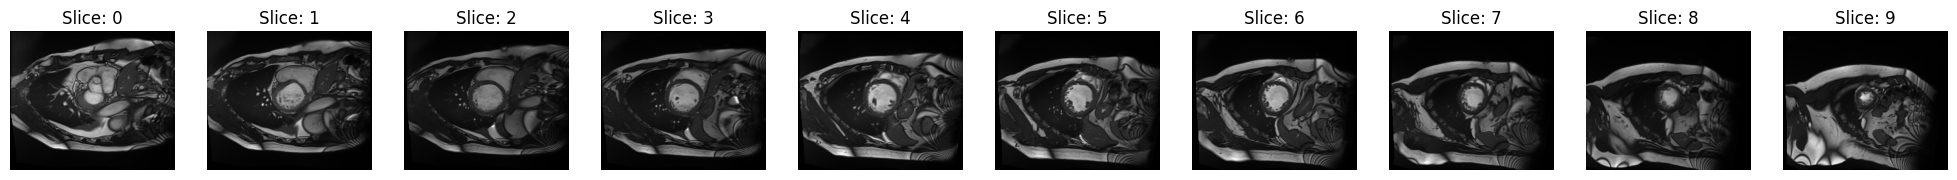

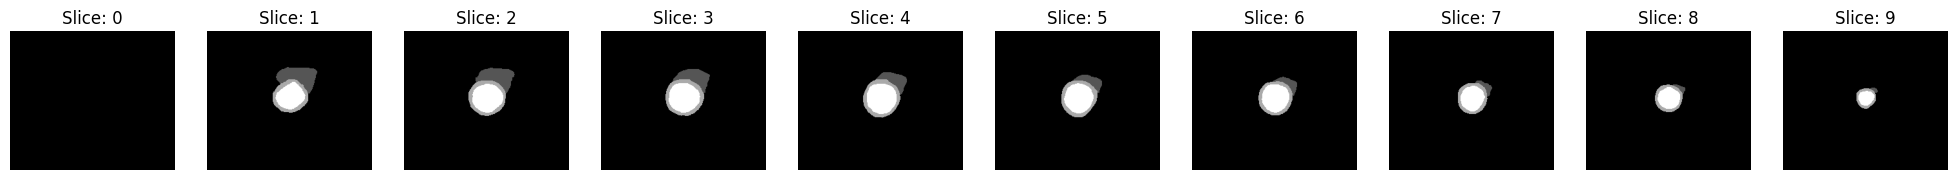

In [4]:
# Show images and masks
patient = 0
example_image = pre.heart_mask_loader( [ images_train_ED_path[patient] ] )
example_mask = pre.heart_mask_loader( [ masks_train_ED_path[patient] ] )
pre.visualize_image_mask(*example_image, *example_mask, example_image[0].shape[2])

Comparing the data of different patients, it can be observed that the relative position of the left and right ventricles varies. Therefore, in order to remove this source of variability, the 3D segmentation masks are rotated so that those structures are horizontally aligned, with the LV on the left and the RV on the right. This is done by the method ```align_heart_mask``` implemented on *preprocessing.py*. Essentially a line between the center of those two heart strutures is identified and its angle with the horizontal axis is computed, the image is then rotated by the negative of that value.

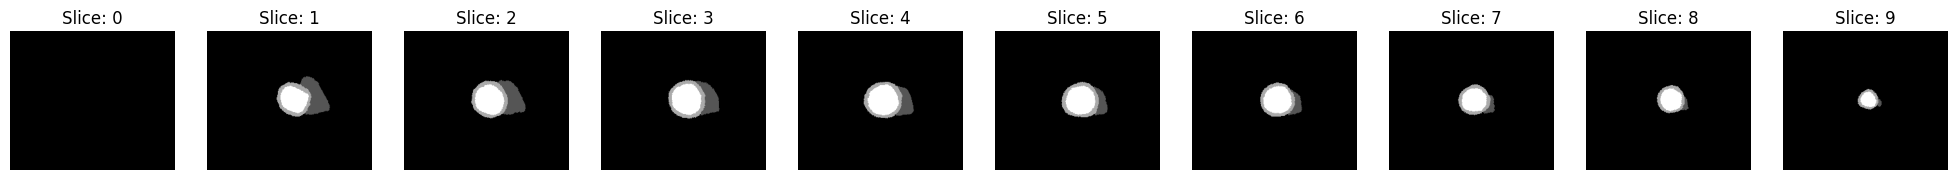

In [5]:
# Rotate masks so that the relative position of the LV and RV is always the same
example_mask = pre.align_heart_mask( example_mask )
pre.visualize_mask( *example_mask )

Also, the MRI scans include structures other than the LV, RV and MY, resulting in a large useless background area in the segmentation masks. Therefore the 3D segmentation masks are cropped to the smallest square containing the heart structures of interest, this is done by the method ```crop_heart_mask``` implemented on *preprocessing.py*.

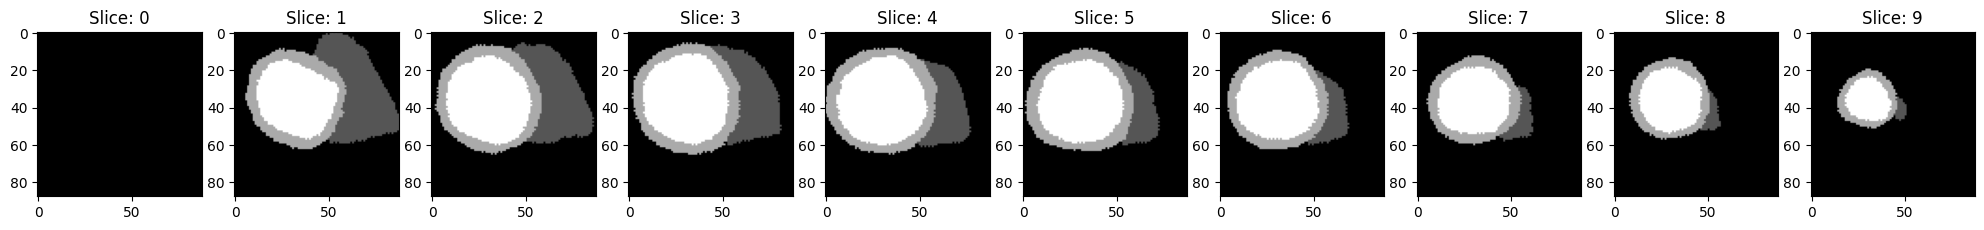

In [6]:
# Crops masks
example_mask = pre.crop_heart_mask( example_mask )
pre.visualize_mask( *example_mask, show_axis=True )

However, the cropping process results in segmentation masks of different sizes and the size of the input images of the VAE must be standardized. To solve this issue, the segmentation masks are either downsampled or upsampled using the nearest neighbour interpolation method so that each frame is of size $128 \times 128$, this is done by the method ```resize_heart_mask``` implemented on *preprocessing.py*.

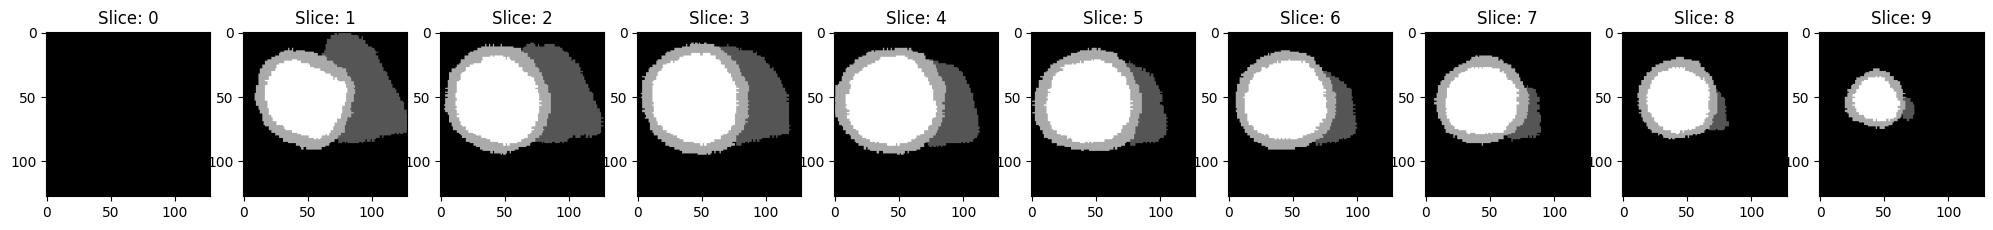

In [7]:
# Standardize image size (inputs of the network must be of same size)
example_mask = pre.resize_heart_mask(example_mask)
pre.visualize_mask( *example_mask, show_axis=True )

Once the 3D segmentation masks are aligned and cropped and their sizes standardized, their frames are decoupled (this is done by the method ```convert_3D_to_2D``` implemented on *preprocessing.py*.) and treated as independent 2D images.

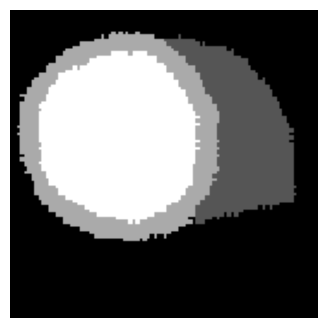

In [8]:
# Separate the frames, each frame will treated as a 2D image
example_mask = pre.convert_3D_to_2D(example_mask)

idx = 3
pre.visualize_2d_mask(example_mask[idx])

Up to this point, we have 2D segmentation masks with labels 0, 1, 2 and 3 corresponding to the background, RV, MY and LV, respectively. However we would like to have a one-hot encoding of the segmentation mask, i.e., one binary mask per channel. This transformation of the encoding is done by the method ```heart_mask_extraction``` inplemented on *preprocessing.py*.

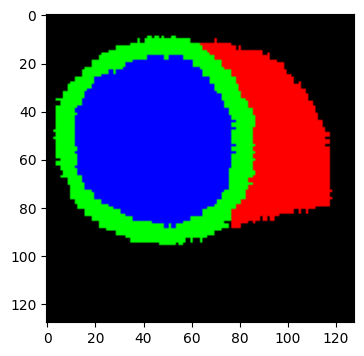

In [9]:
# Translate multilabel mask into multi channel mask (each channel represents a different structure),
# the axis are ordered according to PyTorch standard: (channel, height, width)
example_mask = pre.heart_mask_extraction(example_mask)
pre.visualize_multichannel_mask( example_mask[idx] )

All those pre-processing steps are combined on the method ```preprocessingPipeline```, implemented on *preprocessing.py*, that allows their efficient application to the entirety of the dataset. The resulting arrays are passed to a PyTorch DataLoader in order to be used to train and test the VAE.

In [10]:
train_data = pre.preprocessingPipeline(masks_train_ED_path)
test_data = pre.preprocessingPipeline(masks_test_ED_path)

In [11]:
# Saving the pre-processed dataset
pre.saveDataset(train_data, path+'./', 'ED_train_data')
pre.saveDataset(test_data, path+'./', 'ED_test_data')

In [12]:
# Loading the pre-processed dataset
train_data = pre.loadDataset(path+'./', 'ED_train_data')
test_data = pre.loadDataset(path+'./', 'ED_test_data')

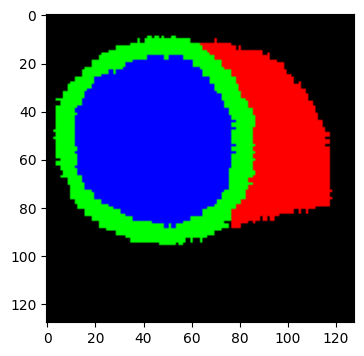

In [13]:
# Check that the data was correctly imported
test_idx = 3
pre.visualize_multichannel_mask(train_data[test_idx])

## VAE

A Variational Autoencoder is a type of generative model that learns to encode and decode data, allowing for the generation of new samples that resemble the training data. It consists of an encoder network, a decoder network, and a latent space representation. All the architecture of the VAE is implemented in the class ```VAE``` in *model.py*.

The general architecture of the VAE is illustrated in the figure bellow.

![VAE](images/image_vae.png)

Where:
$$Z = \mu + \sigma \epsilon$$
$$\epsilon \sim \mathcal{N}(0, 1)$$.

The encoder network takes as input an image and transforms it into a lower-dimensional representation in the latent space. In our implementation, the encoder consists of four convolutional blocks, followed by fully connected layers. Each convolutional block is composed of two layers. The architecture present in the first block is the following:

- *2D Convolutional layer*: `input = 4, output = 48, kernel_size = 2x2, stride = 2`
- *2D Convolutional layer*: `input = 48, output = 48, kernel_size = 3x3, padding = 1`

The output of each first layer in the subsequent blocks is duplicated in relation to the size of its corresponding input.

These convolutional layers extract relevant features from the input image, while the fully connected layers map the these features to the mean, $\mu$, and log variance, $\sigma$, of the latent space distribution, which are then used to sample a point in the latent space. The size of the input for the fully connected layers are computed using the function `compute_fc_input_dim`, available in *model.py*. We considered creating a fake tensor to be more efficient in computing the output when going through the convolutional layers.

The decoder network takes a point in the latent space as input and recontructs the original imagem from it. In our implementation, it mirrors the architecture of the encoder network.


During the training, the VAE aims to minimize the recontruction error between the original image (encoder input) and the recontructed image (decoder output). To measure this error, we use the *Soft Dice Loss*, which is the measure of the overlap between two samples, the predicted and the ground truth masks. The Soft Dice Loss is defined as:

$$L_{Dice} = 1 - \frac{2 \sum_{i=1}^{N} p_i g_i + \epsilon}{\sum_{i=1}^{N} p_i^2 + \sum_{i=1}^{N} g_i^2 + \epsilon}$$

Where $p_i$ and $g_i$ are the predicted and ground truth values, respectively, and $\epsilon$ is a small constant to avoid division by zero.

Additionally, the *Kullback-Leibler Divergence (KLD) Loss* is used to encourage the latent space distribution to resemble a Gaussian distribution. The KLD loss is defined as:

$$L_{KLD} = -\frac{1}{2} \sum_{i=1}^{N} (1 + log(\sigma_i^2) - \mu_i^2 - \sigma_i^2)$$

Where $\mu_i$ and $\sigma_i$ are the mean and standard deviation of the latent space distribution, respectively, and $N$ is the number of dimensions of the latent space.

For the model, the following values are used in order to preserve good results.

- `batch_size = 64`: number of samples evaluated in each training iteration
- `z_dim = 32`: dimension of the latent space
- `lamb = 1e-2`: trade off hyperparameter for the KLD to generate different samples
- `learning_rate = 6e-5`: learning rate of the Adam optimizer, with suggestion from the paper [2]
- `l2 = 0.01`: regularization parameter for the Adam optimizer

In [14]:
import torch
import model as m
import model_evaluation as eval

In [25]:
# if the .py is changed, run to reload
import importlib
importlib.reload(m)
importlib.reload(eval)

<module 'model_evaluation' from '/content/drive/MyDrive/Télécom/2A/IMA/IMA206/project/Variational-Auto-Encoders-for-cardiac-shape-modeling/model_evaluation.py'>

In [26]:
# Decide in which device we want to run on
if (torch.cuda.is_available()):
  device = torch.device("cuda:0")
else:
  device = "cpu"

print("Running on", device)

Running on cuda:0


In [31]:
batch_size = 64

# Define train, validation and test sets
train_set, val_set, test_set = torch.utils.data.random_split(np.concatenate([train_data, test_data], axis=0), [0.6, 0.2, 0.2])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

In [32]:
# Define the dimensions of the input space
n_channels = 4
n_rows = n_cols = train_data[0].shape[-1]
z_dim = 32
lamb = 1e-2

# Create an instance of the VAE model
model = m.VAE(n_rows, n_cols, n_channels, z_dim, lamb).to(device)

In [35]:
# Define the optimizer
learning_rate = 6e-5
l2 = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2)

In [20]:
num_epochs = 100
train_loss = []
val_loss = []
for epoch in range(num_epochs):
    new_train_loss, new_val_loss = model.train_one_epoch(optimizer, train_loader, val_loader, epoch=epoch, device=device)
    train_loss.append(new_train_loss)
    val_loss.append(new_val_loss)

Epoch: 0	Average train loss: 0.7973
		Average validation loss: 0.7921
Epoch: 1	Average train loss: 0.7927
		Average validation loss: 0.7868
Epoch: 2	Average train loss: 0.7818
		Average validation loss: 0.7738
Epoch: 3	Average train loss: 0.7712
		Average validation loss: 0.7711
Epoch: 4	Average train loss: 0.7686
		Average validation loss: 0.7688
Epoch: 5	Average train loss: 0.7661
		Average validation loss: 0.7664
Epoch: 6	Average train loss: 0.7522
		Average validation loss: 0.7469
Epoch: 7	Average train loss: 0.6969
		Average validation loss: 0.7193
Epoch: 8	Average train loss: 0.6556
		Average validation loss: 0.6591
Epoch: 9	Average train loss: 0.6297
		Average validation loss: 0.5971
Epoch: 10	Average train loss: 0.6106
		Average validation loss: 0.5934
Epoch: 11	Average train loss: 0.5974
		Average validation loss: 0.5830
Epoch: 12	Average train loss: 0.5809
		Average validation loss: 0.5510
Epoch: 13	Average train loss: 0.5636
		Average validation loss: 0.5342
Epoch: 14	Averag

Total epochs:  100


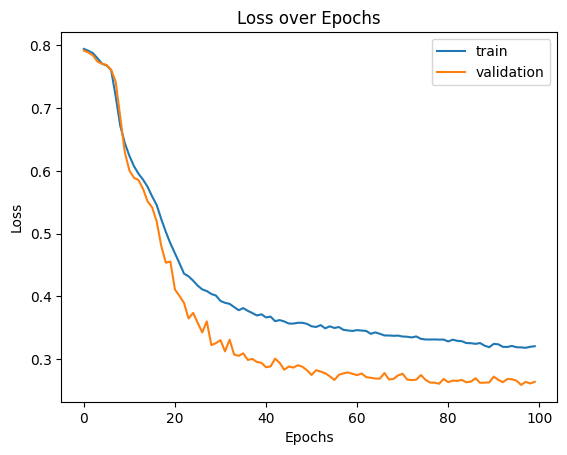

Test loss:  0.26862802409162423


In [ ]:
# Plot train and validation losses...
eval.plot_loss(train_loss, val_loss)
# ... and evalutate test loss
print( "Test loss: ", model.compute_test_loss(test_loader, device) )

## Results

In this section we present the results obtained with the Variational Autoencoder implemented in the previous section. The VAE was trained for 100 epochs with a batch size of 64 and a learning rate of 6e-5. The loss function used was the Soft Dice Loss.

Below we present the original segmentations masks and the corresponding recontruction obtained with the trained modeel.

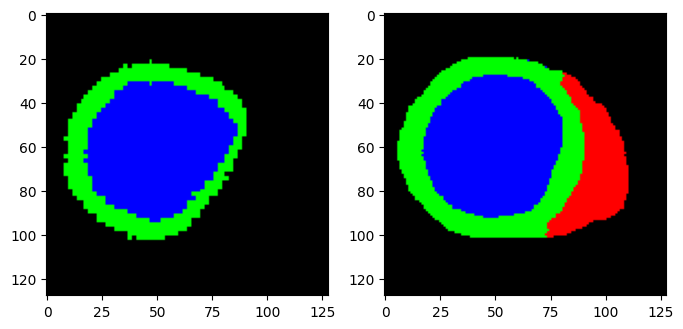

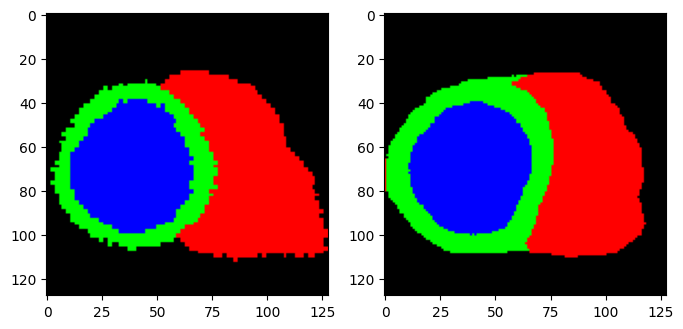

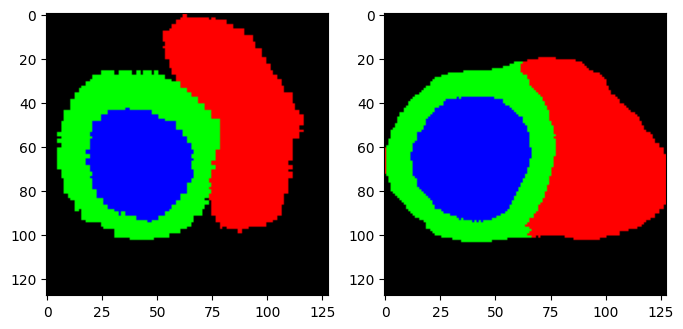

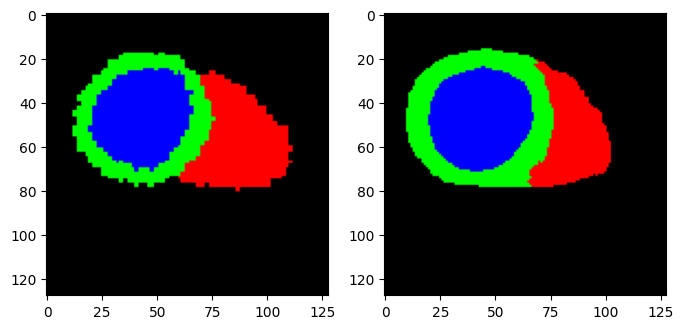

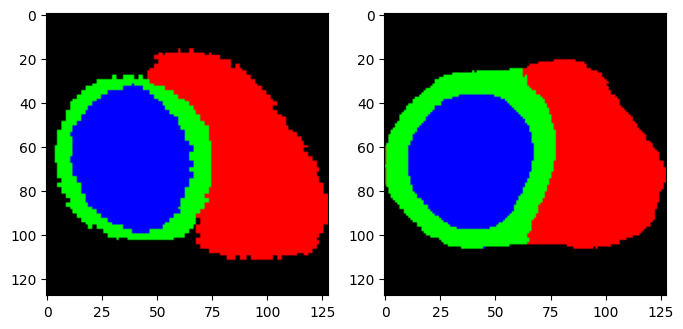

In [ ]:
# Visualize test set reconstruction
data = next(iter(test_loader))[:5]
eval.visualize(model, data, device=device)

In [ ]:
# Save model so that we don't have to retrain every time
torch.save(model.state_dict(), path+'./model.pt')

In [ ]:
# Load saved model
model = m.VAE(n_rows, n_cols, n_channels, z_dim).to(device)
model.load_state_dict(torch.load(path+'./model.pt', map_location=device))

<All keys matched successfully>

To better understand the quality of the reconstructions obtained with the VAE, we present below the best and worst reconstructions obtained with the trained model.

In [ ]:
recon_losses, original_images, reconstructed_images, indices = eval.sorted_recon_losses(model, test_loader, device)

Below we present the best recontructions obtained with the trained model that showcase the ability to accurately reconstruct the segmentation masks. The model was able to preserve the main characteristics of the cardiac structures, such as the ventricles and the myocardium.

Best Recontructions:


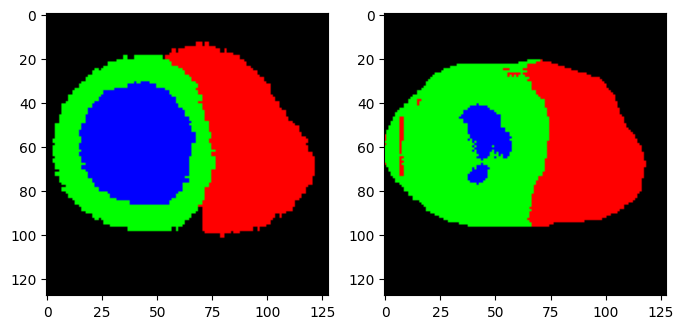

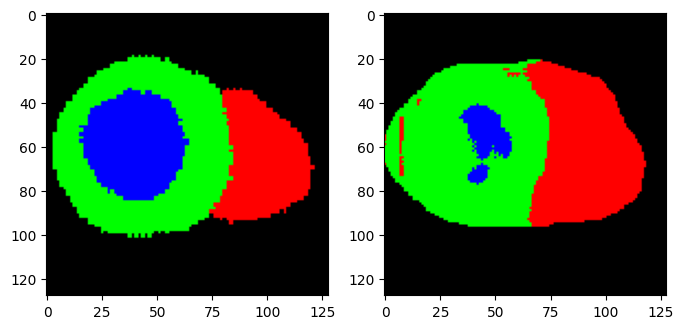

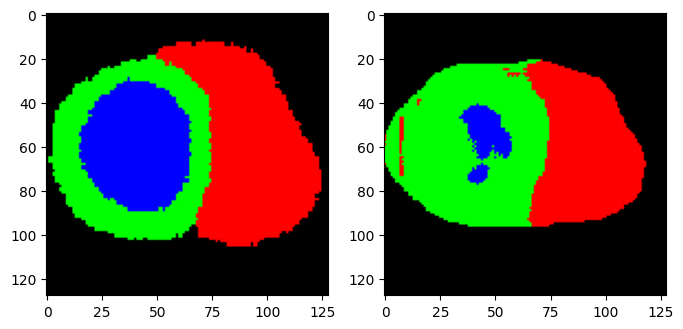

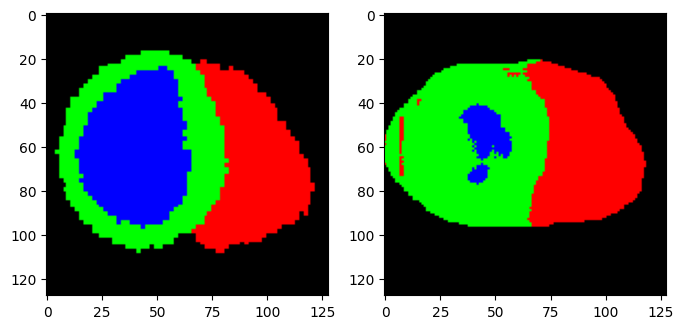

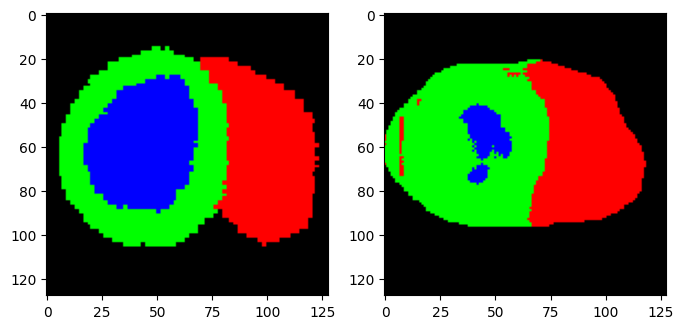

In [ ]:
# Visualize test set reconstruction (ordered by reconstruction loss)
# Best recontruction
print("Best Recontructions:")
data_best = original_images[indices[:5]]
eval.visualize(model, data_best, device=device)

The worst recontructions are exhibit below. As it is possible to see, the model was not able to reproduce tith a high accuracy the original image, specifically in these cases where the original image is all black (background).

Worst Recontructions:


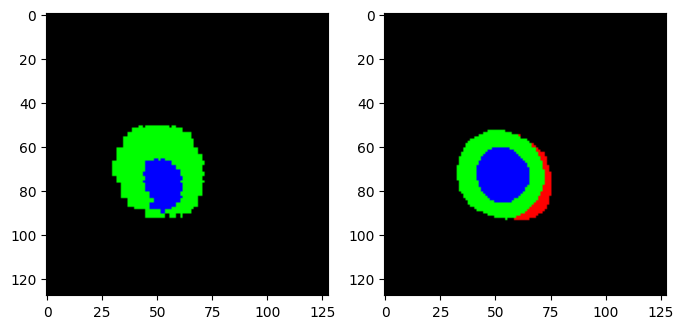

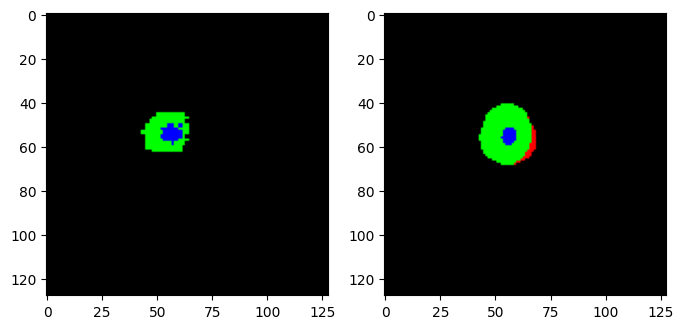

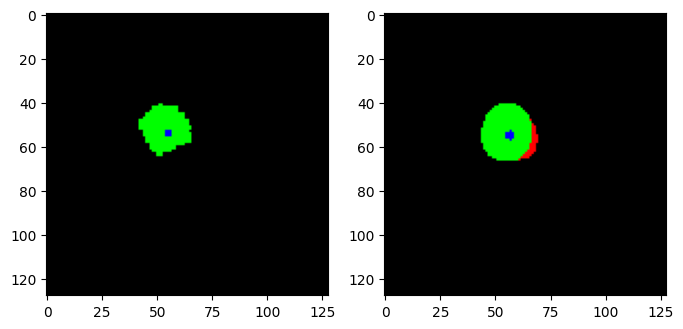

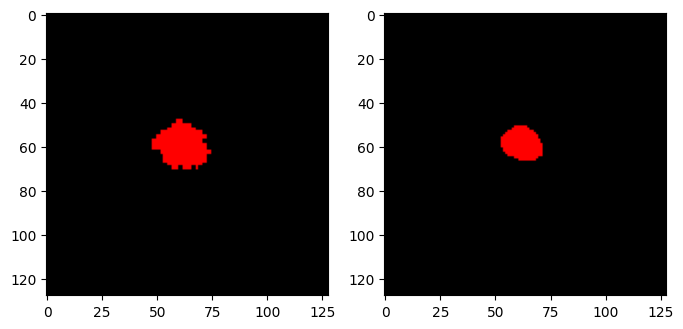

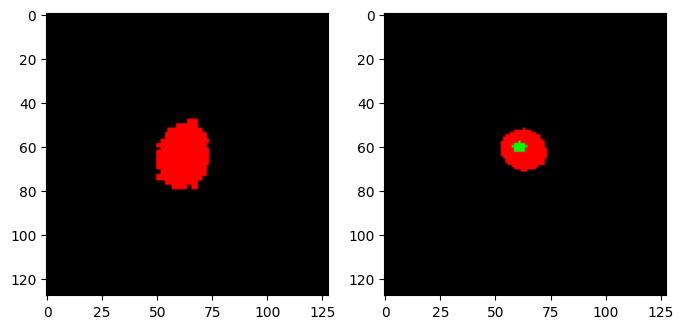

In [ ]:
print ("Worst Recontructions:")
data_worst = original_images[indices[-5:]]
eval.visualize(model, data_worst, device=device)

### Latent space

In [ ]:
# Let's see how the latent space is organized

# Generate mu and logvar
mus, logvars = eval.generate_latent(model, train_loader, device)

# Check if the distribution is normal
eval.check_distribution(mus, logvars)

Mu: mean=-0.35795462131500244, std=3.2803380489349365
Std: mean=0.014433827251195908, std=0.012918710708618164


Text(0, 0.5, 'Principal Component 2')

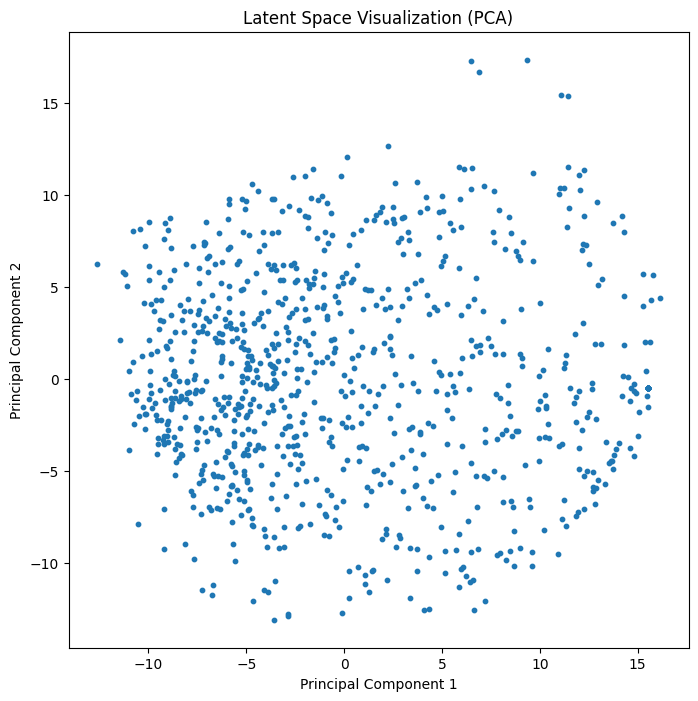

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors

# Move latent vectors to CPU
latent_vectors_cpu = mus.cpu().numpy()

# Perform dimensionality reduction using PCA
pca = PCA(n_components=2, random_state=42)
latent_pca = pca.fit_transform(latent_vectors_cpu)

# Plot the latent space with PCA
plt.figure(figsize=(8, 8))
plt.scatter(latent_pca[:, 0], latent_pca[:, 1], s=10)
plt.title('Latent Space Visualization (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Text(0, 0.5, 'Principal Component 2')

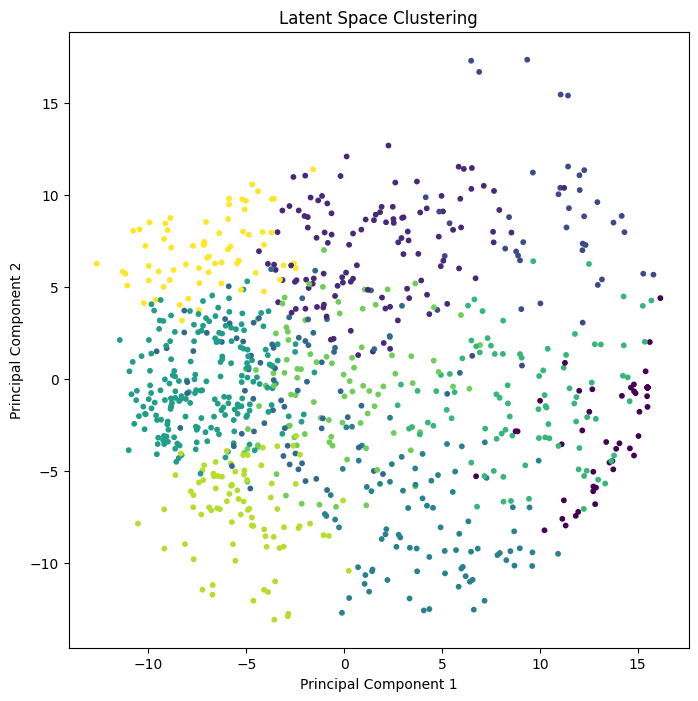

In [ ]:
# Perform clustering on the latent vectors
kmeans = KMeans(n_clusters=10, random_state=42)
clusters = kmeans.fit_predict(latent_vectors_cpu)

# Plot the clusters in the latent space
plt.figure(figsize=(8, 8))
plt.scatter(latent_pca[:, 0], latent_pca[:, 1], c=clusters, cmap='viridis', s=10)
plt.title('Latent Space Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

### Generative model


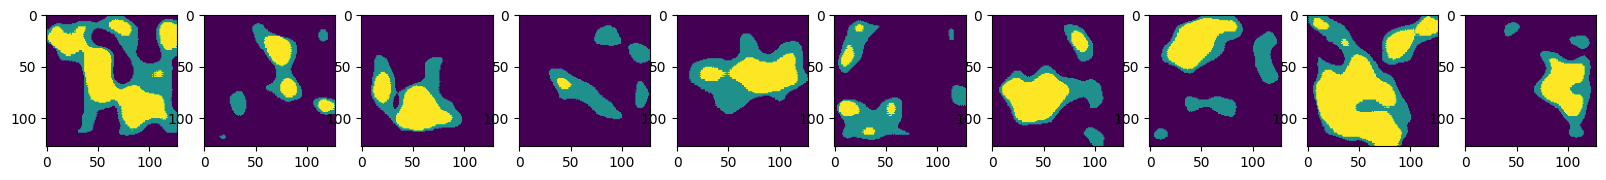

In [ ]:
num_samples = 10
samples = model.generate_samples1(num_samples, device)

eval.visualize_generated_images1(samples)

TypeError: ignored

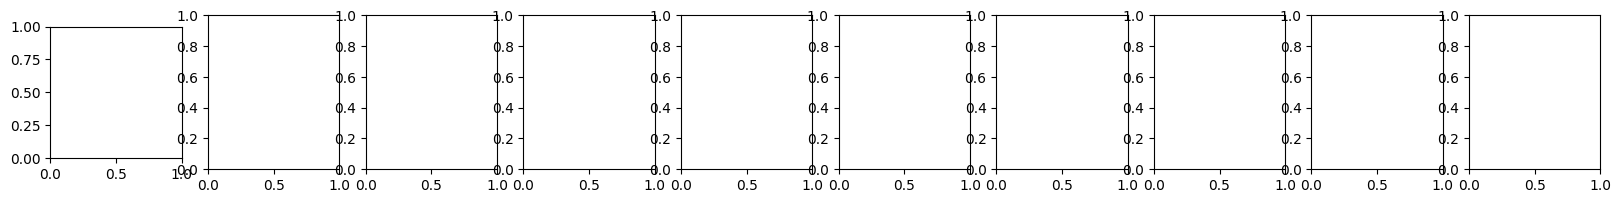

In [ ]:
#impplementation of the tp

num_samples = 10
samples = model.generate_samples2(num_samples, device)

eval.visualize_generated_images1(samples)
